# Markov Chain Monte Carlo (MCMC) Sampling: 
---
[Toward Data Science: Monte Carlo Markov Chain (MCMC), Exlplained](https://towardsdatascience.com/monte-carlo-markov-chain-mcmc-explained-94e3a6c8de11)
- about drawing samples from a given distribution: *estimating using randomness*
- **Independent Samples:** averages over samples can be used as unbiased estimators of expected values of parameters in the distribtuion 
    - *Discrete Samples:*
        - *law of large numbers:* growing sample base, fraction of an instance corresponds to its probability 
    - *Continuous Samples:*
        - analogous reasoning applies to a given region of the sample space 
- **Practical Challenge:** ensuring independent sampling because the distribution is *unknown*
    - *dependent samples* can still be unbiased (tend to increase estimate's variance)
    - more smples will be needed for a more precise estimate 


#### Sampling from a Multivariate Distribution is Computationally Demanding: number of *states* increases **exponentially** with the number of *dimensions*

#### [Stochastic:](https://en.wikipedia.org/wiki/Stochastic)
- modeling approach for a random probability distribution 
- means "aim" or "guess" in greek
- *Stochastic Process* -> *Random Process*

## Monte Carlo Methods:
---
- Rely on repeated random sampling to approximate results (memoryless)
- may be determinisitc -> do not permit an exact analytical solution 
- **Identify** and **Explore** regions of the *posterior* that concentrate significant probability density 
    - converges when it consistently moves through nearby high-probability states of the posterior where acceptance rates increase 
    - *Challenge*: balance need for random exploration withthe risk of reducing the acceptance rate 
- developed during Manhattan Project for the Atomic Bomb

> ## Monte Carlo Method applied to a Markov Chain Process: 
> 1. Start at *Current* Position
> 2. Draw a *New* Position from a *Proposal Distribution*
> 3. Evaluate the Probability of the Nw Position in Light of *Data* and *Prior Positions*
>       - if sufficiently likely -> move to new position 
>       - otherwise -> remain at current position 
> 4. *Repeat from *Step 1**
> 5. After a Given Number of Iterations, Return all Accepted Positions 

- *Initial Steps* are typically more reflective of the starting position than the posterior
    - typically discarded as: *Burn-In *Samples**
    - should forget about initial starting point after a certain number of iterations 
- *Remaining Samples* are called the **TRACE** of the process
    - *law of large numbers*: relative frequency of samples approximates the posterior and can be used to compute expected values 

### Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt 

from datetime import date, datetime, timedelta as td 

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import seaborn as sns 

from matplotlib.axis import Axis

%matplotlib inline

# [Example](https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98)
---
[GitHub](https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb)

- Use sleep data to create a model that specifies the posterior probability of sleep as a function of time 
- time = continuous variable 
    - unable to specify the entire posterior distribution 
    - turn to methods that approximate a distribution (aka MCMC)

### [How To Analyze Apple Health Data With Python](https://www.python-engineer.com/posts/apple-health-data-python/)
### [Analyse your Health with Python and Apple Health](https://towardsdatascience.com/analyse-your-health-with-python-and-apple-health-11c12894aae2)

# Apple Health Data XML -> CSV
--- 


### Import `.csv` Data 

In [98]:
df = pd.read_csv('data/steps_distance.csv')

### Grouping Data By: *Year, Month, Day, and Day of Week Index*

In [99]:
df['endDate'] = pd.to_datetime(df['endDate'])

df['year'] = df['endDate'].dt.year
df['month'] = df['endDate'].dt.month
df['day'] = df['endDate'].dt.day
df['day_of_week'] = df['endDate'].dt.day_of_week

df

,endDate,StepCount,DistanceWalkingRunning,year,month,day,day_of_week
0,2021-09-10,3246.0,1.309123,2021,9,10,4
1,2021-09-11,10003.0,4.154720,2021,9,11,5
2,2021-09-12,4812.0,2.097997,2021,9,12,6
3,2021-09-13,4672.0,1.776384,2021,9,13,0
4,2021-09-14,5914.0,2.324539,2021,9,14,1
...,...,...,...,...,...,...,...
449,2022-12-03,12476.0,4.832174,2022,12,3,5
450,2022-12-04,3428.0,1.365090,2022,12,4,6
451,2022-12-05,16428.0,6.891993,2022,12,5,0
452,2022-12-06,12660.0,5.101112,2022,12,6,1


### Monthly Steps

In [100]:
monthly_steps_avg = df.groupby(['year', 'month'])['StepCount'].mean()
monthly_steps_sum = df.groupby(['year', 'month'])['StepCount'].sum()

monthly_steps_avg, monthly_steps_sum

(year  month
 2021  9         8244.333333
       10        8224.935484
       11        8433.200000
       12        7616.451613
 2022  1         6254.032258
       2         7283.071429
       3         8420.709677
       4        10936.133333
       5        11844.967742
       6        12825.633333
       7         9818.548387
       8        12549.225806
       9        12403.066667
       10       11764.645161
       11        9272.233333
       12        9391.428571
 Name: StepCount, dtype: float64,
 year  month
 2021  9        173131.0
       10       254973.0
       11       252996.0
       12       236110.0
 2022  1        193875.0
       2        203926.0
       3        261042.0
       4        328084.0
       5        367194.0
       6        384769.0
       7        304375.0
       8        389026.0
       9        372092.0
       10       364704.0
       11       278167.0
       12        65740.0
 Name: StepCount, dtype: float64)

### External Data Calculations: Rolling Average 

In [153]:
# Copy To New Dataframe - DeepCopy so Changes DO NOT reflect in Original 
daily_steps_sum = df[['endDate', 'StepCount']].copy(deep=True)

# Calculate Rolling Average 
daily_steps_sum['RollingMeanSteps'] = daily_steps_sum.StepCount.rolling(window=10,center=True).mean()
daily_steps_sum.dropna(inplace=True)

daily_steps_sum = daily_steps_sum.set_index('endDate')

daily_steps_sum

,StepCount,RollingMeanSteps
endDate,,
2021-09-15,2819.0,5705.8
2021-09-16,12172.0,6102.8
2021-09-17,2975.0,6354.2
2021-09-18,7697.0,6854.1
2021-09-19,2748.0,6728.5
...,...,...
2022-11-29,13658.0,9989.4
2022-11-30,8805.0,8784.7
2022-12-01,6577.0,9227.1


### Plot Rolling Mean of Step Counts 

### External Data Calculations: Step Count Over Recommended 10k

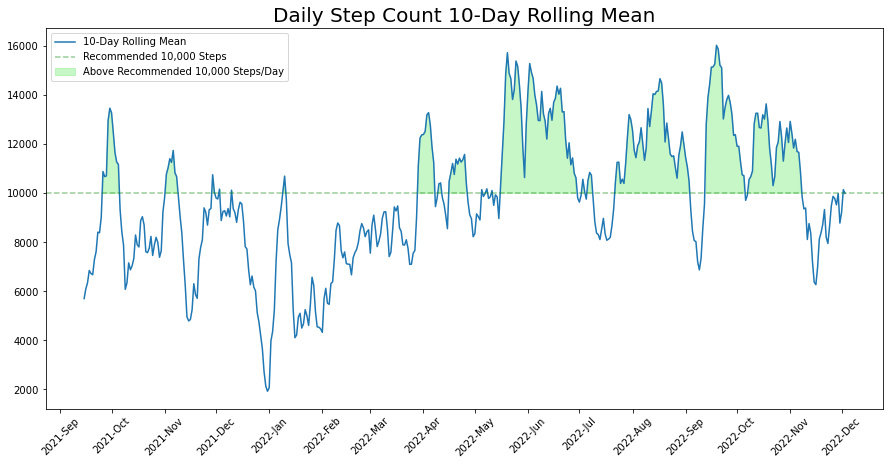

In [179]:
fig, ax = plt.subplots(figsize=(15,7))

y_line = 10000

ax.plot(daily_steps_sum.RollingMeanSteps, label="10-Day Rolling Mean")
ax.axhline(y=y_line, label='Recommended 10,000 Steps', linestyle='--', color='green', alpha=0.4)
ax.fill_between(x=daily_steps_sum.index, y1=y_line, y2=daily_steps_sum['RollingMeanSteps'], where=y_line < daily_steps_sum['RollingMeanSteps'], color='lightgreen', alpha=0.5, label='Above Recommended 10,000 Steps/Day')


ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
Axis.set_major_locator(ax.xaxis, mdates.MonthLocator())
ax.tick_params(axis='x', labelrotation=45)

ax.set_title("Daily Step Count 10-Day Rolling Mean", fontsize=20)
ax.legend(loc=2)

plt.show()

In [176]:
recommended = 10000
over_10_df = df[['endDate', 'StepCount']].copy(deep=True)

# Calculate Days Over Recommended 10,000 Steps 
over_10_df['over_10_count'] = 0
over_10_df.loc[(over_10_df['StepCount'] > recommended), 'over_10_count'] = 1

# Sum By Year and Month 
over_10_df['month'] = over_10_df['endDate'].dt.month 
over_10_df['year'] = over_10_df['endDate'].dt.year
monthly_over_10 = over_10_df.groupby(['year', 'month'])['over_10_count'].sum()
month_days = over_10_df.groupby(['year', 'month'])['over_10_count'].count()

# Calculate Total Number of Days Over 
sum_total = over_10_df['over_10_count'].sum()
total_count = over_10_df['over_10_count'].count()
avg_over = (sum_total/total_count) * 100

average_days_over_10 = (monthly_over_10 / month_days) * 100

average_days_over_10


year  month
2021  9        28.571429
      10       32.258065
      11       40.000000
      12       32.258065
2022  1        19.354839
      2        25.000000
      3        45.161290
      4        56.666667
      5        48.387097
      6        60.000000
      7        45.161290
      8        67.741935
      9        66.666667
      10       67.741935
      11       46.666667
      12       42.857143
Name: over_10_count, dtype: float64